# What's in our codebase?

Robojackets is an organization that has been around more than 20 years, and Robocup has been one of the teams in Robojackets for almost 15 of those. In addition, members of the team are rarely able to stay in the organization for more than a couple of years because they graduate from the university. While leadership is generally passed down effectively, it rarely stays in the hands of the same members for an extended period of time. This can make it difficult to stay organized and keep consistent goals. With these facts in mind, I wanted to explore the main contribution of my subteam (software) and whether our progress as shown in the codebase's data actually aligns with our current goals.

In [1]:
import json
import pandas as pd
from collections import defaultdict
import re
import wordcloud
import matplotlib.pyplot as plt

## Examining the issues

Goals and progress for a team working on the same project can be communicated in many ways. In programming, engineers who work on the same codebase often signal each other about what they are working on through creating issues and pull requests (a request to update the code base). Here we'll examine the most recent open issues in the codebase obtained through GitHub's API and saved as JSON data.

In [2]:
file_path = "robocup-issues1.json"
issues_df = pd.read_json(file_path)

We are examining the most recent 60 issues in this dataset. Some of these are also pull requests (but not all of them).

In [3]:
issues_df.shape

(60, 28)

Here's some of the data contained in the JSON file. Some of this information, like the API url's, is not particular useful for our purposes.

In [4]:
issues_df.head()

,url,repository_url,labels_url,comments_url,events_url,html_url,id,node_id,number,title,...,created_at,updated_at,closed_at,author_association,active_lock_reason,pull_request,body,reactions,timeline_url,performed_via_github_app
0,https://api.github.com/repos/RoboJackets/roboc...,https://api.github.com/repos/RoboJackets/roboc...,https://api.github.com/repos/RoboJackets/roboc...,https://api.github.com/repos/RoboJackets/roboc...,https://api.github.com/repos/RoboJackets/roboc...,https://github.com/RoboJackets/robocup-softwar...,1042930255,PR_kwDOAO78Gc4uAiD9,1742,Two robots passing,...,2021-11-02 23:15:39+00:00,2021-11-02 23:15:39+00:00,NaT,CONTRIBUTOR,NaN,{'url': 'https://api.github.com/repos/RoboJack...,## Description\r\nbasic passing,{'url': 'https://api.github.com/repos/RoboJack...,https://api.github.com/repos/RoboJackets/roboc...,NaN
1,https://api.github.com/repos/RoboJackets/roboc...,https://api.github.com/repos/RoboJackets/roboc...,https://api.github.com/repos/RoboJackets/roboc...,https://api.github.com/repos/RoboJackets/roboc...,https://api.github.com/repos/RoboJackets/roboc...,https://github.com/RoboJackets/robocup-softwar...,1034582888,PR_kwDOAO78Gc4tmQXj,1741,foreach in all plays,...,2021-10-25 01:32:03+00:00,2021-11-02 03:02:40+00:00,NaT,CONTRIBUTOR,NaN,{'url': 'https://api.github.com/repos/RoboJack...,## Description\r\nReplaced repetitive statemen...,{'url': 'https://api.github.com/repos/RoboJack...,https://api.github.com/repos/RoboJackets/roboc...,NaN
2,https://api.github.com/repos/RoboJackets/roboc...,https://api.github.com/repos/RoboJackets/roboc...,https://api.github.com/repos/RoboJackets/roboc...,https://api.github.com/repos/RoboJackets/roboc...,https://api.github.com/repos/RoboJackets/roboc...,https://github.com/RoboJackets/robocup-softwar...,1030848119,PR_kwDOAO78Gc4taVNu,1739,Role stickiness,...,2021-10-20 00:21:02+00:00,2021-11-02 03:23:14+00:00,NaT,CONTRIBUTOR,NaN,{'url': 'https://api.github.com/repos/RoboJack...,## Description\r\nApplied role stickiness\r\n\...,{'url': 'https://api.github.com/repos/RoboJack...,https://api.github.com/repos/RoboJackets/roboc...,NaN
3,https://api.github.com/repos/RoboJackets/roboc...,https://api.github.com/repos/RoboJackets/roboc...,https://api.github.com/repos/RoboJackets/roboc...,https://api.github.com/repos/RoboJackets/roboc...,https://api.github.com/repos/RoboJackets/roboc...,https://github.com/RoboJackets/robocup-softwar...,1030845227,PR_kwDOAO78Gc4taUmf,1738,"working action, untested server",...,2021-10-20 00:14:30+00:00,2021-11-03 00:54:34+00:00,NaT,CONTRIBUTOR,NaN,{'url': 'https://api.github.com/repos/RoboJack...,temp again to see CI,{'url': 'https://api.github.com/repos/RoboJack...,https://api.github.com/repos/RoboJackets/roboc...,NaN
4,https://api.github.com/repos/RoboJackets/roboc...,https://api.github.com/repos/RoboJackets/roboc...,https://api.github.com/repos/RoboJackets/roboc...,https://api.github.com/repos/RoboJackets/roboc...,https://api.github.com/repos/RoboJackets/roboc...,https://github.com/RoboJackets/robocup-softwar...,1007534072,PR_kwDOAO78Gc4sSMjX,1733,Removed HML and replaced with arbitrary floats,...,2021-09-26 23:20:58+00:00,2021-11-01 00:39:28+00:00,NaT,NONE,NaN,{'url': 'https://api.github.com/repos/RoboJack...,Removed HML and replaced all uses of HML in ta...,{'url': 'https://api.github.com/repos/RoboJack...,https://api.github.com/repos/RoboJackets/roboc...,NaN


In [5]:
issues_df = issues_df.drop(columns=["url","repository_url","labels_url","comments_url","events_url","html_url"])

To get an idea of what topics are most commonly addressed in these issues, we will be counting the mentions of specific terms, then visualizing their frequency.

In [6]:
word_counts_dict = defaultdict(int)

In [7]:
def get_word_counts(text, word_count_dict=word_counts_dict):
    split_words = text.split(" ")
    #regex below makes sure to remove the \n characters where applicable (first capture group)
    clean_re = re.compile('''\\n*([\w]{2,})|([\w]{2,})''')
    matches = re.findall(clean_re, text)
    for match in matches:
        word_count_dict[match[0].lower()] += 1
    return

In [8]:
%%capture
issues_df["title"].apply(get_word_counts)
issues_df["body"].apply(get_word_counts)

In [9]:
multiple_counts = {word: word_counts_dict[word] for word in word_counts_dict if word_counts_dict[word] >= 2}

In [10]:
words_for_cloud = " ".join(title for title in issues_df.title) + " " + " ".join(body for body in issues_df.body)
print ("There are {} total words in these issues.".format(len(words_for_cloud)))

There are 25838 total words in these issues.


First, we'll visualize these in a word cloud, with the largest words representing the most frequently seen terms. I took out some words, like urls that linked to specific sections of code and the term "Description" that appeared in the body of almost every issue when formatted according to team specs.

In [11]:
stopwords = wordcloud.STOPWORDS
dont_use = ["https","github","software","RoboJackets","robocup","will","Description", "description", "robojackets","TODO","todo","issue"]
stopwords.update(dont_use)
wordcloud = wordcloud.WordCloud(background_color="white", stopwords=stopwords).generate(words_for_cloud)

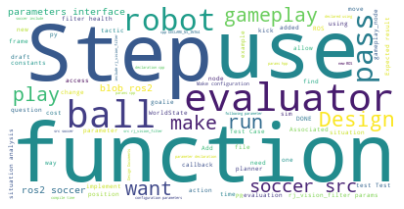

In [12]:
plt.figure(figsize=[7,7])
plt.axis("off")
plt.imshow(wordcloud, interpolation="bilinear")
plt.savefig("issues_cloud.png",format="png")
plt.show()

If we simply want to see this frequency with actual numbers, here are the same results represented with a bar chart. Many of these words are seen only a few times but, our total number of issues examined in the data set is only 60. Seeing a word merely twice would mean it potentially occurs in nearly 5% of issues (assuming each word is only seen once in each issue). As before, some common words like "in", "at", "Robojackets", ect. are not included because they are not particularly useful to examine.

In [13]:
#stopwords
multiple_counts = {word: multiple_counts[word] for word in multiple_counts if word not in stopwords}
#let's look at top 15 only
word_count = pd.Series(multiple_counts)
word_count = word_count.sort_values(ascending=False)

In [14]:
word_count[0:19]

soccer        32
parameters    27
make          22
cpp           21
using         20
blob          19
test          19
use           19
parameter     19
design        19
ball          18
pass          16
functions     15
params        15
kick          14
ros           14
interface     13
new           13
situation     13
dtype: int64

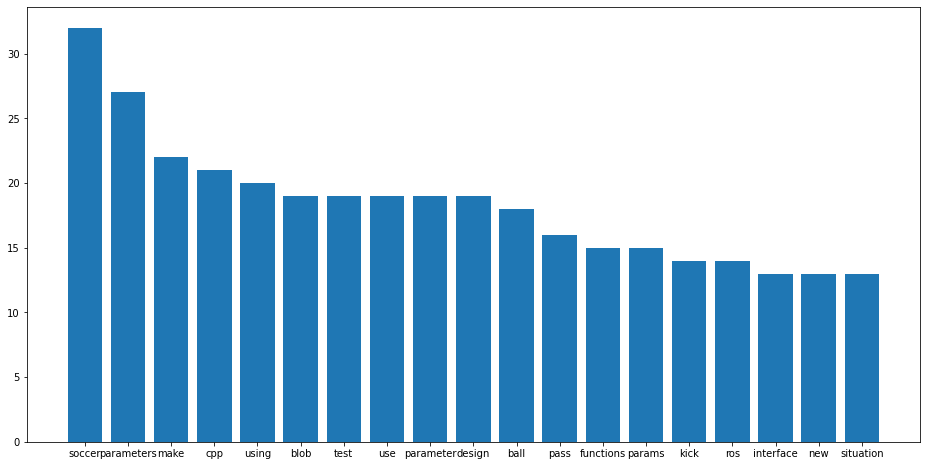

In [15]:
plt.figure(figsize=[16,8])
plt.bar(word_count[0:19].index, word_count[0:19])
#plt.set_ylabel("Number of Issues")
#plt.set_xlabel("Keyword")
plt.show()